<a href="https://colab.research.google.com/github/Camicb/practice/blob/main/Travel_Insurance_Claim_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Travel Insurance Claim Prediction**

#1. Introduction

Many companies selling tickets or travel packages, give consumers the option to purchase travel insurance, also known as travelers insurance. Travel insurance is a type of insurance that covers the costs and losses associated with traveling. It is useful protection for those traveling domestically or abroad.
Some travel policies cover damage to personal property, rented equipment, such as rental cars, or even the cost of paying a ransom. 

The objective of this project is to create a machine learning model for a insurance company to predict if the insurance buyer will claim their travel insurance or not.

#2. Import Required Libraries

In [ ]:
#!pip install -U imbalanced-learn
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
#!pip install pycaret
#!pip install scikit-learn

In [37]:
#Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import set_config
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from pycaret.utils import enable_colab
enable_colab()


Colab mode enabled.


#3. Exploratory Data Analysis
##3.1 About the data
There are 11 columns in the dataset:
*   **Duration:** Travel duration
*   **Destination:** Travel destination (country)
*   **Agency:** Agency Name
*   **Agency Type:** Travel Agency or Airlines 
*   **Commission (in value):** Commission on the insurance
*   **Age:** Age of the insurance buyer
*   **Gender:** Gender of the insurance buyer
*   **Distribution Channel:** offline/online
*   **Product Name:** Name of the insurance plan
*   **Net Sales:** Net sales
*   **Claim:** If the insurance is claimed or not (the target variable), 0 = not claimed, 1 = claimed


In [3]:
# Load the provided data into a pandas data frame 
ins = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Training_set_label.csv" ) # training data
test_ins = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Testing_set_label.csv') # testing data

## 3.2 Exploratory data analysis

In [4]:
ins.head()
ins.info()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,11.88,NaN,29,0
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,0.00,NaN,36,0
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,0.00,NaN,25,0
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,13.63,M,24,0
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,0.00,NaN,23,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                48260 non-null  object 
 1   Agency Type           48260 non-null  object 
 2   Distribution Channel  48260 non-null  object 
 3   Product Name          48260 non-null  object 
 4   Duration              48260 non-null  int64  
 5   Destination           48260 non-null  object 
 6   Net Sales             48260 non-null  float64
 7   Commision (in value)  48260 non-null  float64
 8   Gender                13899 non-null  object 
 9   Age                   48260 non-null  int64  
 10  Claim                 48260 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 4.1+ MB


In [5]:
test_ins.head()
test_ins.info()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,EPX,Travel Agency,Online,Cancellation Plan,24,HONG KONG,27.0,0.0,NaN,36
1,EPX,Travel Agency,Online,Cancellation Plan,51,JAPAN,45.0,0.0,NaN,36
2,EPX,Travel Agency,Online,Cancellation Plan,52,JAPAN,21.0,0.0,NaN,21
3,EPX,Travel Agency,Online,Cancellation Plan,89,SINGAPORE,11.0,0.0,NaN,30
4,EPX,Travel Agency,Online,Cancellation Plan,5,MALAYSIA,10.0,0.0,NaN,33


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15832 entries, 0 to 15831
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                15832 non-null  object 
 1   Agency Type           15832 non-null  object 
 2   Distribution Channel  15832 non-null  object 
 3   Product Name          15832 non-null  object 
 4   Duration              15832 non-null  int64  
 5   Destination           15832 non-null  object 
 6   Net Sales             15832 non-null  float64
 7   Commision (in value)  15832 non-null  float64
 8   Gender                4546 non-null   object 
 9   Age                   15832 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 1.2+ MB


The variable Claim is treated as numerical in the training dataset, so it will be transformed into a categorical one.

In [6]:
# Statistic report
profile = ProfileReport(ins, html={'style': {'full_width': True, 'primary_color': '#30b6c2'}},  samples=None, missing_diagrams=None, interactions=None)
profile.to_file("report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

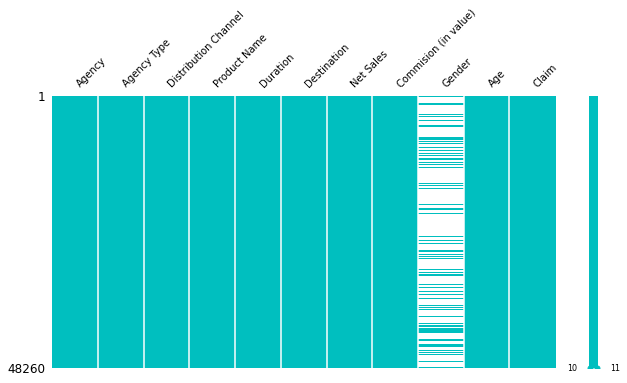

In [7]:
# Visualization of missing values 
msno.matrix(ins, figsize=(10,5), fontsize=10, color=(0.0, 0.75, 0.75)) 

Since 'Gender' has too many missing values and the 'Distribution Channel' is highly correlated to others variables and presents imbalanced classes, the entire columns will be removed. Then, the training data will be splited into a new training and validation sets.

In [8]:
# Selecting the variables
X=ins.drop(['Gender', 'Distribution Channel', 'Claim'], axis=1) 
y=ins['Claim']

#Spliting the data with stratification into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1, stratify=y)

In [9]:
X_train.head()
X_train.info()

,Agency,Agency Type,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
10176,EPX,Travel Agency,Cancellation Plan,10,"KOREA, REPUBLIC OF",24.0,0.00,36
39025,EPX,Travel Agency,2 way Comprehensive Plan,53,THAILAND,93.0,0.00,36
41061,JZI,Airlines,Basic Plan,67,HONG KONG,26.0,9.10,30
19917,CWT,Travel Agency,Rental Vehicle Excess Insurance,6,"TAIWAN, PROVINCE OF CHINA",29.7,17.82,42
21110,JZI,Airlines,Value Plan,39,JAPAN,58.0,20.30,31


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41021 entries, 10176 to 36504
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                41021 non-null  object 
 1   Agency Type           41021 non-null  object 
 2   Product Name          41021 non-null  object 
 3   Duration              41021 non-null  int64  
 4   Destination           41021 non-null  object 
 5   Net Sales             41021 non-null  float64
 6   Commision (in value)  41021 non-null  float64
 7   Age                   41021 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 2.8+ MB


In [10]:
y_train.value_counts()

0    40419
1      602
Name: Claim, dtype: int64

# 4. Data wrangling and Feature enginnering

Changes in the testing data are executed in order to maintain a consistent shape with the training data.

In [11]:
pd.set_option('mode.chained_assignment',None) # no warnings

## 4.1 Agency 


([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

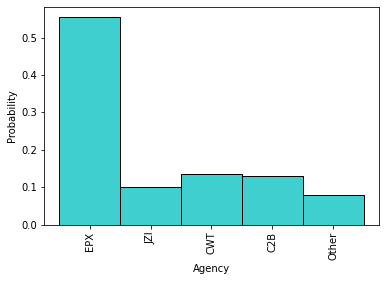

In [12]:
# Replacing the agencies with a frequency smaller than 5% to 'Other' 
Agencies=X_train.loc[:,'Agency'].value_counts(normalize=True)*100
Agencies=list(Agencies[Agencies < 5].index)

X_train.loc[:,'Agency']=X_train.loc[:,'Agency'].apply(lambda i: 'Other' if i in Agencies else i)
X_test.loc[:,'Agency']=X_test.loc[:,'Agency'].apply(lambda i: 'Other' if i in Agencies else i) 

sns.histplot(data=X_train, x='Agency', color='c', stat='probability')
plt.xticks(rotation='vertical')

##4.2 Product Name

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

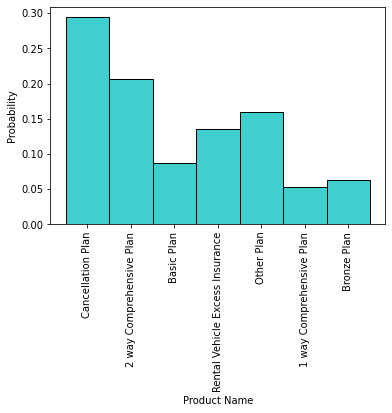

In [13]:
# Replacing the products with a frequency smaller than 5% to 'Other Plan'
Products=X_train.loc[:, 'Product Name'].value_counts(normalize=True)*100
Products=list(Products[Products < 5].index)

X_train['Product Name']=X_train['Product Name'].apply(lambda i: 'Other Plan' if i in Products else i)
X_test['Product Name']=X_test['Product Name'].apply(lambda i: 'Other Plan' if i in Products else i)

sns.histplot(data=X_train, x='Product Name', color='c', stat='probability')
plt.xticks(rotation='vertical')

##4.3 Duration and Age

In [14]:
# Transforming the values equal or smaller than zero for Duration and equal to 118 for Age for being clearly outliers.
X_train['Duration']= X_train.loc[:, 'Duration'].apply(lambda i: np.nan if i < 1 else i)
X_train['Duration'].isnull().value_counts(normalize=True)*100
print('---')
X_train['Age']= X_train.loc[:,'Age'].apply(lambda i: np.nan if i == 118 else i)
X_train['Age'].isnull().value_counts(normalize=True)*100

False    99.895176
True      0.104824
Name: Duration, dtype: float64

---


False    98.43251
True      1.56749
Name: Age, dtype: float64

In [15]:
# Imputing NaN values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train['Age'] = imputer.fit_transform(X_train[['Age']]).ravel()
X_train['Duration'] = imputer.fit_transform(X_train[['Duration']]).ravel()

##4.4 Destination

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text major ticklabel objects>)

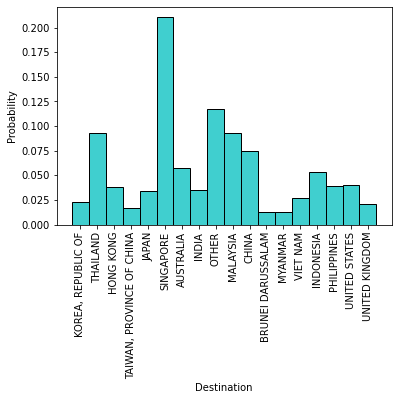

In [16]:
# Replacing the Destinations with a frequency smaller than 1% to 'OTHER'
Destination=X_train.loc[:, 'Destination'].value_counts(normalize=True)*100
Destination=list(Destination[Destination > 1].index)

X_train['Destination']=X_train['Destination'].apply(lambda i: 'OTHER' if i not in Destination else i)
X_test['Destination']=X_test['Destination'].apply(lambda i: 'OTHER' if i not in Destination else i)

sns.histplot(data=X_train, x='Destination', color='c', stat='probability')
plt.xticks(rotation='vertical')

##4.5 Total sales : Net Sales and Commision (in  value)

In [17]:
# Adding both values since 55% of the commision values are zero
X_train['Total sales']= X_train['Commision (in value)'] + X_train['Net Sales']
X_test['Total sales']= X_test['Commision (in value)'] + X_test['Net Sales']

In [18]:
# Droping columns for being highly correlated now
X_train=X_train.drop(columns=['Commision (in value)','Net Sales'], axis=1)
X_test=X_test.drop(columns=['Commision (in value)','Net Sales'], axis=1)
X_train.head()


,Agency,Agency Type,Product Name,Duration,Destination,Age,Total sales
10176,EPX,Travel Agency,Cancellation Plan,10.0,"KOREA, REPUBLIC OF",36.0,24.00
39025,EPX,Travel Agency,2 way Comprehensive Plan,53.0,THAILAND,36.0,93.00
41061,JZI,Airlines,Basic Plan,67.0,HONG KONG,30.0,35.10
19917,CWT,Travel Agency,Rental Vehicle Excess Insurance,6.0,"TAIWAN, PROVINCE OF CHINA",42.0,47.52
21110,JZI,Airlines,Other Plan,39.0,JAPAN,31.0,78.30


In [19]:
# Encoding the categorical variables with one hot encoding
X_train=pd.get_dummies(X_train, columns=['Agency','Agency Type','Product Name','Destination'])  
X_test=pd.get_dummies(X_test, columns=['Agency','Agency Type','Product Name','Destination'])  

In [20]:
# SMOTE-oversampling the minority class in the target variable
sm = SMOTE(random_state = 25, sampling_strategy = 0.5)
X_train, y_train= sm.fit_sample(X_train, y_train)

In [21]:
y_train.value_counts()

0    40419
1    20209
Name: Claim, dtype: int64

In [22]:
# Checking the shape of the data for modeling
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(60628, 35)

(60628,)

(7239, 35)

(7239,)

# 5. Modeling
  
I will use a python library called pycaret to compare possible models to adress this problem and then I will select the top 3 to work with.

In [23]:
# Setting up enviroment
from pycaret.classification import *

train=pd.concat([X_train, y_train], axis=1)
test=pd.concat([X_test, y_test], axis=1) #validation data

clf=setup(train, target='Claim', test_data=test, session_id=1190)

,Description,Value
0,session_id,1190
1,Target,Claim
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(60628, 36)"
5,Missing Values,False
6,Numeric Features,35
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
# Comparing classifiers and choosing the top 3
compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9839,0.9927,0.9768,0.9751,0.9752,0.9633,0.9641,3.133
catboost,CatBoost Classifier,0.9847,0.9951,0.9669,0.9869,0.9751,0.9642,0.9659,20.988
rf,Random Forest Classifier,0.9838,0.9950,0.9711,0.9803,0.9744,0.9627,0.9639,3.892
lightgbm,Light Gradient Boosting Machine,0.9773,0.9944,0.9574,0.9741,0.9641,0.9476,0.9492,0.599
xgboost,Extreme Gradient Boosting,0.9757,0.9941,0.9583,0.9686,0.9619,0.9442,0.9457,14.662
dt,Decision Tree Classifier,0.9727,0.9702,0.9597,0.9590,0.9578,0.9377,0.9392,0.208
knn,K Neighbors Classifier,0.9159,0.9722,0.9661,0.8157,0.8845,0.8191,0.8264,0.952
lr,Logistic Regression,0.9225,0.9768,0.8374,0.9229,0.8771,0.8209,0.8237,6.346
ridge,Ridge Classifier,0.9121,0.0000,0.8568,0.8766,0.8661,0.8008,0.8013,0.072
lda,Linear Discriminant Analysis,0.9116,0.9726,0.8568,0.8753,0.8654,0.7997,0.8003,0.296


## 5.1 Extra Trees Classifier

In [30]:
et = create_model('et', verbose=False)

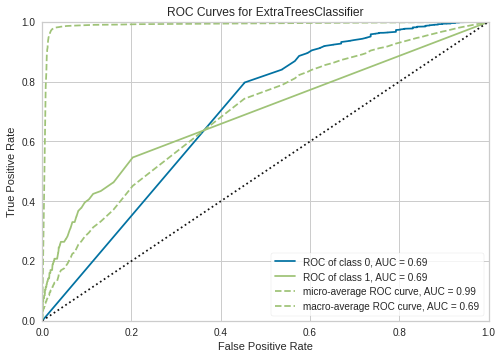

In [36]:
plot_model(et) #Area Under the Curve

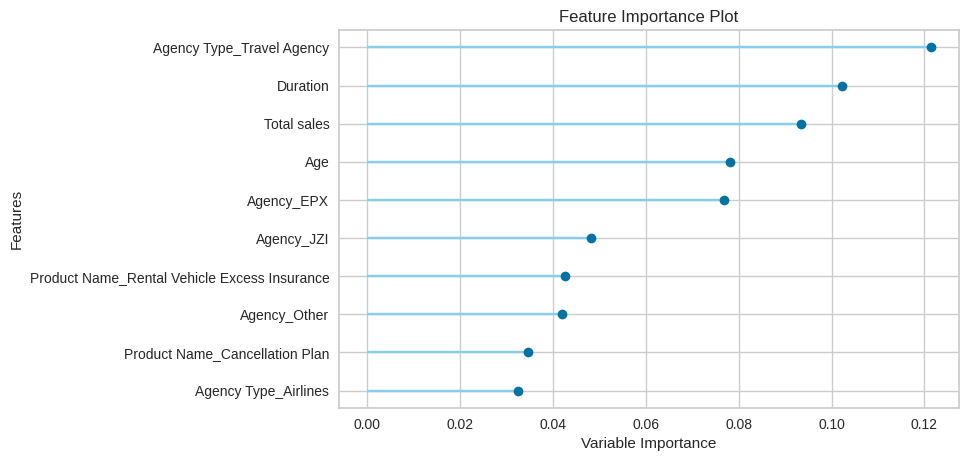

In [35]:
plot_model(et, plot='feature')

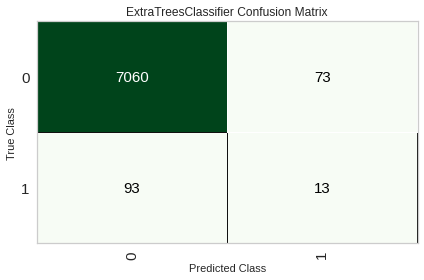

In [42]:
plot_model(et, plot='confusion_matrix') 

## 5.2 CatBoost Classifier

In [31]:
catboost=create_model('catboost', verbose=False)

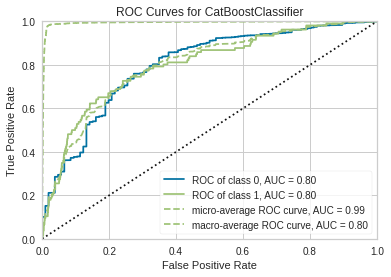

In [47]:
plot_model(catboost) #Area Under the Curve

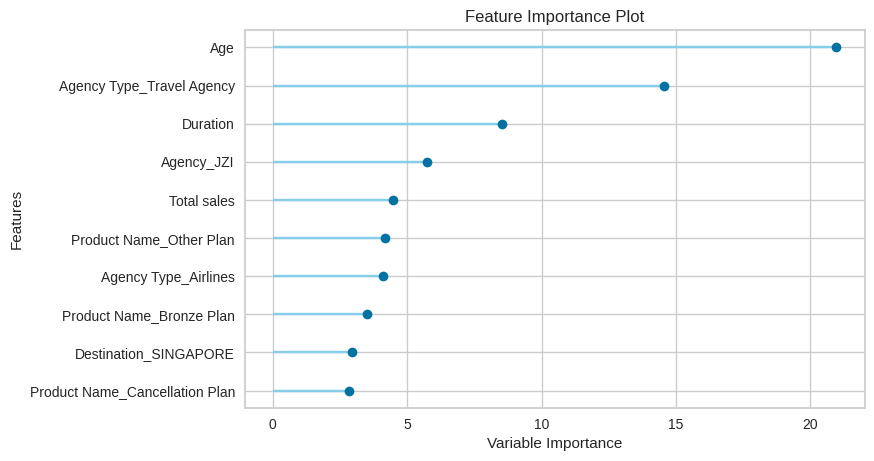

In [48]:
plot_model(catboost, plot='feature')

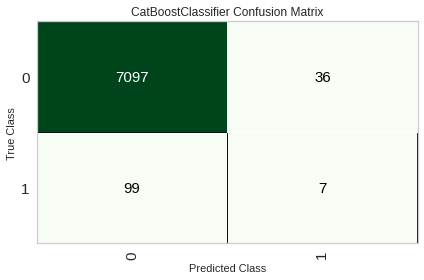

In [49]:
plot_model(catboost, plot='confusion_matrix') 

## 5.3 Random Forest Classifier

In [32]:
rf = create_model('rf', verbose=False)

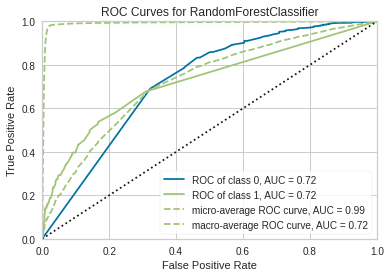

In [50]:
plot_model(rf) #Area Under the Curve

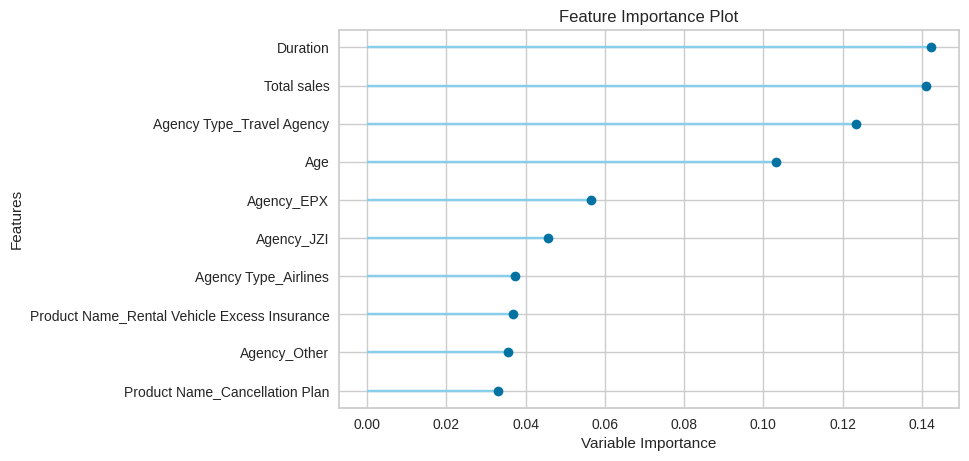

In [51]:
plot_model(rf, plot='feature')

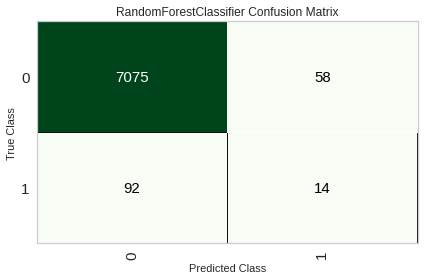

In [52]:
plot_model(rf, plot='confusion_matrix') 

Since Random Forest has a good AUC and the smaller error Type II (92 False Negatives), I will use it for predictions on the real test data. First, I will try to tuned the model.

In [ ]:
plot_model(rf, plot='parameter') 